In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pandas as pd

import torch.nn.functional as F
from typing import List, Literal
import math, os
import matplotlib.pyplot as plt
from Transformer.transformer_model import TransformerAttention, DatasetFromCsvFile, evaluate

In [4]:
ROOT_DIR = os.path.dirname(os.path.abspath(""))
assert ROOT_DIR.endswith("Synthesis-Project-1"),\
	"Root directory is not Synthesis-Project-1. Ensure your python file is in the 'src/' directory of the repository"

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerAttention(dim=200, depth=2, heads=4, mlp_dim=512, max_sequence_length=310, local_window_size=5, device=device).to(device)
model.load_state_dict(torch.load(ROOT_DIR + "/models/Transformer/transformer_model.pt"))
model.eval()

TransformerAttention(
  (codiascii_to_embedding): Linear(in_features=1, out_features=200, bias=True)
  (multi_scale_attention_layers): ModuleList(
    (0-1): 2 x MultiScaleAttention(
      (local_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
      )
      (global_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=200, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=200, bias=True)
      )
      (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (regression_head): Sequential(
    (0): Linear(in_features=200, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): 

In [8]:
max_sequence_length_dataset = 150
batch_size = 512
test_filename = ROOT_DIR + "/data/test.csv"
test_dataset = DatasetFromCsvFile(test_filename, max_sequence_length_dataset)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
from tqdm import tqdm

# Modified evaluate function to return the targets and outputs
def evaluate(
    model: torch.nn.Module,
    data_loader: DataLoader,
    loss_history: List[float],
    device: torch.device
) -> float:
	model.eval() # evaluation mode

	targets = []
	outputs = []

	with torch.no_grad(): # Disable gradient computation
		for i, (data, target) in tqdm(enumerate(data_loader), total=len(data_loader)): # Iterate over the data
			data = data.to(device)
			target = target.to(device).float()
			output = model(data).squeeze()  # Squeeze to match target shape
			targets.extend(target.cpu().numpy())
			outputs.extend(output.cpu().numpy())

	targets = np.array(targets)
	outputs = np.array(outputs)
	return targets, outputs

In [15]:
targets, outputs = evaluate(model, test_data_loader, [], device)

100%|██████████| 158/158 [01:59<00:00,  1.32it/s]


In [20]:
targets = 1-targets
outputs = 1-outputs
targets[:10], outputs[:10]

(array([0. , 0. , 0.5, 0. , 0. , 0. , 0.3, 0. , 0.3, 0. ], dtype=float32),
 array([0.00162727, 0.00559485, 0.49041224, 0.01022995, 0.0078423 ,
        0.01392293, 0.38234204, 0.07560408, 0.37223858, 0.00391775],
       dtype=float32))

In [21]:
len(np.where(targets == 0)[0]), len(targets)

(39903, 80851)

In [18]:
# check where targets is 1 and outputs is close to 0
here = np.where((targets == 1) & (outputs < 0.6))
len(outputs[here])

252

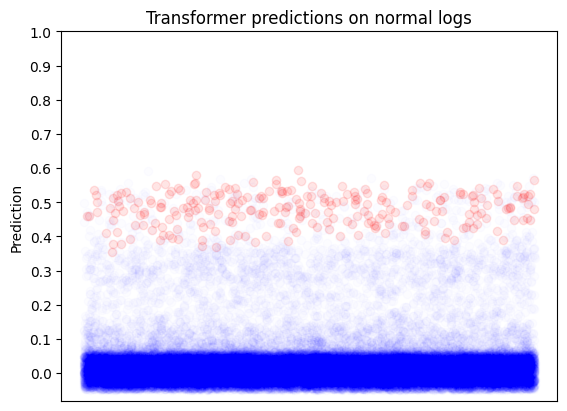

In [24]:
import numpy as np

# Define the amount of jitter
jitter_amount = 0.05

# Add jitter to the data
jitter_targets_1 = targets[targets==0] + np.random.uniform(-jitter_amount, jitter_amount, size=len(targets[targets==0]))
jitter_outputs_1 = outputs[targets==0] + np.random.uniform(-jitter_amount, jitter_amount, size=len(outputs[targets==0]))

jitter_targets_here = targets[here] + np.random.uniform(-jitter_amount, jitter_amount, size=len(targets[here]))
jitter_outputs_here = outputs[here] + np.random.uniform(-jitter_amount, jitter_amount, size=len(outputs[here]))

# Plot the data with jitter
plt.scatter(jitter_targets_1, jitter_outputs_1, alpha=0.01, color='blue')
plt.scatter(jitter_targets_here, jitter_outputs_here, alpha=0.1, color='red')
plt.xticks([])
plt.ylabel('Prediction')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Transformer predictions on normal logs')
plt.show()

In [79]:
log_anomalies = test_dataset.data.iloc[here]

pd.set_option('display.max_colwidth', None)

log_csv = pd.read_csv('test.csv')
print(log_csv.columns)
log_csv.loc[log_anomalies.index, ['URL']].head(252)
# write this in a csv file
log_csv.loc[log_anomalies.index, ['URL']].to_csv('anomalies.csv', index=False)


Index(['URL', 'status', 'bytess', 'user_agent', 'level', 'petition__',
       'petition_CONNECT', 'petition_GET', 'petition_HEAD', 'petition_OPTIONS',
       'petition_POST', 'petition_USER', 'petition_PUT'],
      dtype='object')
